## Libraries

In [1]:
#NLTK package
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize

#for vizualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#for dark theme
#from jupyterthemes import jtplot
#jtplot.style(theme='chesterish')

#so that warnings don't appear
import warnings
warnings.filterwarnings("ignore")

#for text exploration
import string
import os
from collections import defaultdict

# t-SNE and Scikit-Learn package
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import seaborn as sns

# bockeh plotting for t-SNE
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
from bokeh.io import output_file, show
from bokeh.plotting import figure
import matplotlib.colors as mcolors

#for scrapping
from bs4 import BeautifulSoup
import urllib
import requests

#for word embeding - word2vec
import gensim
import glob

/Users/Lamazere/miniconda3/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


# Part 1: How to pre-process textual data 

## A. Chose a relevant corpus of texts 

There are plenty of sources to analyze on the internet and the little experience we have had in working in Legal departments and Law firms is that a majority of the time spent is for searching online for the source that will confirm one’s thought or infirm it.
There is the official government website *Légifrance* that contains the legislative and regulatory texts and court decisions of the supreme courts and appeals under French law.

We therefore decided to run a small script that uses 2 main logics:
- the first one was to run several loops, one for fetching all weblinks containing every decision, and one for opening all them and writing them in separate files.
- the second one was needed a tool that would support dynamic content with Selenium package, as the texts that appear on the user’s interface naturally come from the search query that was sent to the server.

In [6]:
path = "/Users/lamazere/Desktop/Pour mémoire/MasterThesis_git repo"
os.chdir(path)

%run -i 'scrapping.py' #scrapping.py is the python file, which, once runed, asks the user the research query

What are you lookning for ? école
Which year?2018
name of directory ?école_scrapped


## B. Exploration of the corpus

Once we have scrapped our corpus of texts from Légifrance for 2018, we want to learn more about the composition of the texts. 
In order to do so, we use the *tokenization process*. Tokenization will separate the elements of a sentence, called tokens. More precisely we use the function word_tokenize that works as following :

In [4]:
test = "Bonjour, je sert d'exemple pour la thèse de Master. Essayons !"

nltk.word_tokenize(test)

['Bonjour',
 ',',
 'je',
 'sert',
 "d'exemple",
 'pour',
 'la',
 'thèse',
 'de',
 'Master',
 '.',
 'Essayons',
 '!']

We can observe several problems to this function: the punctuation is considered as a token and the apostrophes are considered as part of a word and concatenate two different words.

The process of correcting the punctuation errors is called *text normalization*. Once we have normalized the corpus of text, we create a function that will count the frequency of words as well as the total number of words. In order to calculate the frequency of each word, we use the *bag-of words model*. 

### Without transformation

In [21]:
tokenizer=nltk.RegexpTokenizer(r'\w+')

# Creation of a dictionary database with arrays of tokens of each text
path="/Users/lamazere/Desktop/Pour mémoire/all_2018"

def load_all_texts(number_texts=len(os.listdir(path))):
    db = {}
    for i in range(1,number_texts):
        try:
            droit=open(path+"/text%s.txt"%i,"r").read()
        except FileNotFoundError:
            droit=open(path+"/text%s.txt"%(6968),"r").read()
        db[i]=tokenizer.tokenize(droit.lower())
    return db

db = load_all_texts();

In [22]:
print('Loading of {} texts in the db'.format(len(db.keys())))

Loading of 8717 texts in the db


In [28]:
# Creation of a function that counts the frenquency and the total length of the corpus
def freq_stats_corpora():
    corpora = db

    stats, freq = dict(), dict()
    freq_totale = nltk.Counter()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v) } 
        freq_totale += freq[k]
    return (freq_totale, freq, stats, corpora)

freq_totale, freq, stats, corpora = freq_stats_corpora()

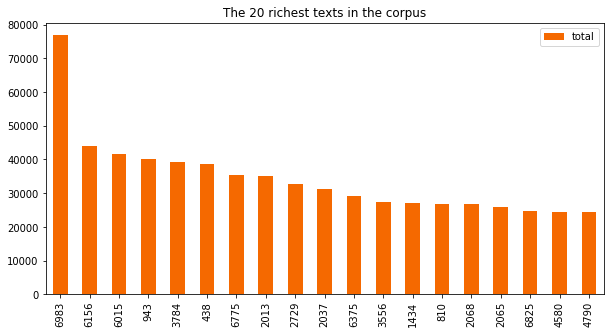

In [29]:
# Recuperation of the length
df_st = pd.DataFrame.from_dict(stats, orient='index')

# Print the 20 richest texts in the corpus
df1_st = df_st.sort_values('total', ascending=False)
df2_st = df1_st.iloc[0:19,:].copy()
df2_st.plot(kind='bar', color="#f56900", title='The 20 richest texts in the corpus',figsize=(10,5));                                     

Thanks to this function we can see that our corpus is quite rich in words as the richest text contains about 40000 words. We can also notice that very rapidly, the number of words remains more or less the same, which is quite logical as legal texts are quite standardized.

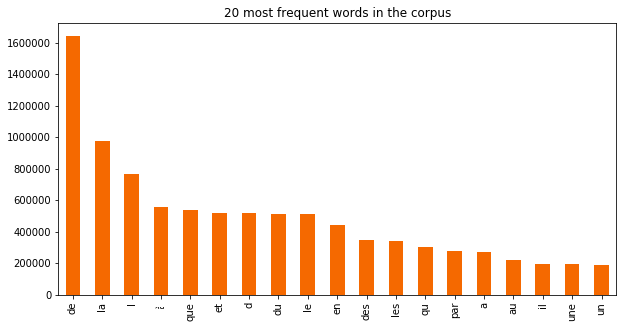

In [30]:
# Recuperation of the frequency
freq_totale, freq, stats, corpora = freq_stats_corpora()
df_fq = pd.DataFrame.from_dict(freq_totale, orient='index')

# Print the 20 most frequent words in the corpus
df1_fq = df_fq.sort_values(0, ascending=False)
df2_fq = df1_fq.iloc[0:19,:].copy()
df2_fq.plot(kind='bar', color="#f56900",legend=False, title='20 most frequent words in the corpus',figsize=(10,5));

When we plot the most frequent words, we can’t help but noticing that we only plotted the most common words in French language.

At this stage, we clearly sea that we need to clean our tokens as almost all most frequent words are the ones that are meaningless. Let's remove all stopwords and use some stemming to clean our corpus. To do that, let's find the most frequent words in our whole corpus (in all our texts).

### With stopwords removal

In [64]:
most_freq = next(zip(*freq_totale.most_common(85)))

print(most_freq)

('de', 'la', 'l', 'à', 'que', 'et', 'd', 'du', 'le', 'en', 'des', 'les', 'qu', 'par', 'a', 'au', 'il', 'une', 'un', 'pour', 'est', 'n', 'sur', 'pas', 'dans', 'société', 'ne', 'm', 'qui', 'cour', 'aux', 'article', 'code', 'ce', 'son', 'y', 'x', 'sa', 'appel', 'été', 'arrêt', 'ou', 's', 'fait', 'elle', 'travail', 'être', 'cette', 'avait', 'alors', 'était', 'mme', '1', 'procédure', 'ses', 'moyen', 'se', 'ainsi', 'avoir', 'ces', 'sans', 'euros', 'demande', 'titre', 'cassation', 'civile', 'contrat', '2', 'motifs', 'lui', 'décision', 'attendu', 'même', 'avec', 'leur', 'droit', 'dont', 'ont', 'sont', 'somme', '3', 'non', 'chambre', 'deux', 'peut')


From the most frequent words we decide to create our own personalized stopwords composed of the 85 most frequent words as well as the default stop words in the NLTK library.

In [65]:
sw = set()
default = nltk.corpus.stopwords.words('french')

sw.update(most_freq)
sw.update(tuple(default))

Let's now create another function to count again the most freq words without those most commun words.

In [34]:
path="/Users/lamazere/Desktop/Pour mémoire/all_2018"

def load_all_texts2(number_texts=len(os.listdir(path))):
    db = {}
    for i in range(1,number_texts):
        try:
            db[i]=open(path+"/text%s.txt"%i,"r").read().lower()
        except FileNotFoundError:
            db[i]=open(path+"/text%s.txt"%(6968),"r").read().lower()
    return db

db2 = load_all_texts2();

In [24]:
print('Loading of {} texts in the db'.format(len(db2.keys())))

Loading of 8717 texts in the db


In [38]:
def freq_stats_corpora2(lookup_table=[], database = db2):
    corpora = defaultdict(list)
    
    for num, text in database.items():
        tokens = tokenizer.tokenize(text)
        corpora[num] += [w for w in tokens if w not in list(sw)]

    stats, freq = dict(), dict()
    freq_totale = nltk.Counter()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v) } 
        freq_totale += freq[k]
    return (freq_totale, freq, stats, corpora)

freq_totale2, freq2, stats2, corpora2 = freq_stats_corpora2()

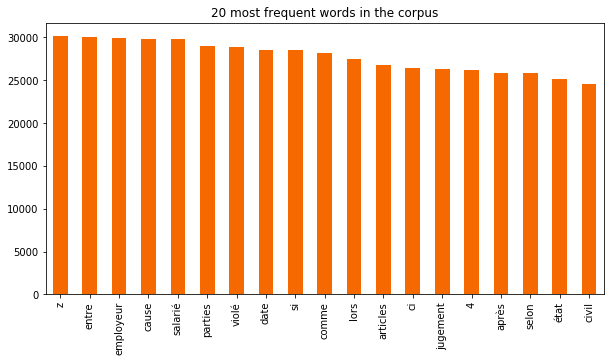

In [17]:
df_fq2 = pd.DataFrame.from_dict(freq_totale2, orient='index')

df1_fq2 = df_fq2.sort_values(0, ascending=False)
df2_fq2 = df1_fq2.iloc[0:19,:].copy()
df2_fq2.plot(kind='bar', color="#f56900", legend=False, title='20 most frequent words in the corpus', figsize=(10,5));                                     


#### Number of Stopwords - hyperparameter

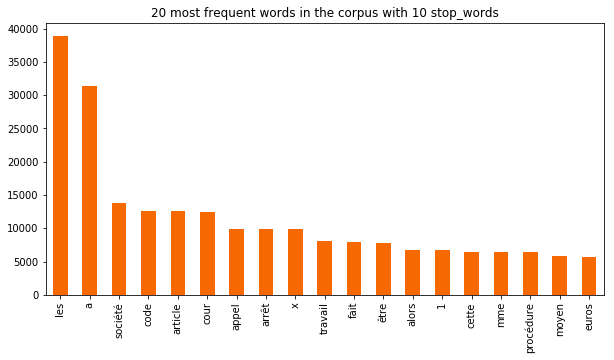

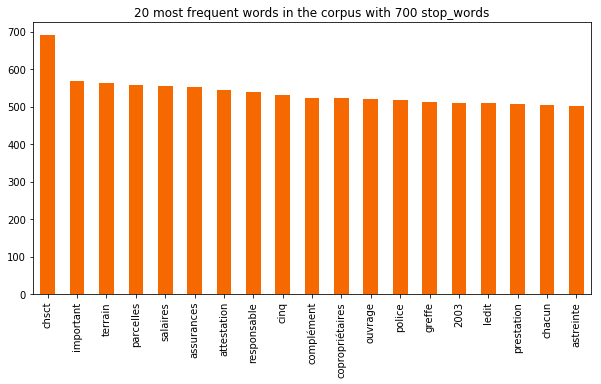

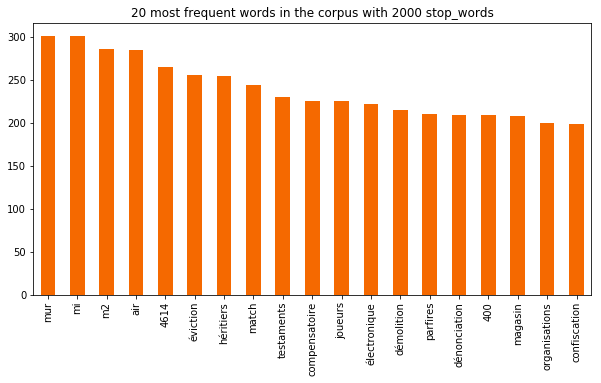

In [41]:
#we look at the effects of number of stopwords on the quality of out texts
#we try on a smaller corpus

db_reduced = load_all_texts2(number_texts = 1000)

for nb_stopwords in [10,700,2000]:
    most_freq = next(zip(*freq_totale.most_common(nb_stopwords)))
    sw = set()
    default = nltk.corpus.stopwords.words('french')
    sw.update(most_freq)
    sw.update(tuple(default))
            
    #load data
    freq_totale2, freq2, stats2, corpora2 = freq_stats_corpora2(database = db_reduced)
    
    #plot   
    df_fq2 = pd.DataFrame.from_dict(freq_totale2, orient='index')
    df1_fq2 = df_fq2.sort_values(0, ascending=False)
    df2_fq2 = df1_fq2.iloc[0:19,:].copy()
    df2_fq2.plot(kind='bar',
                 color="#f56900",
                 legend=False,
                 title='20 most frequent words in the corpus with %d stop_words' % nb_stopwords,
                 figsize=(10,5));                                             

We see a clear improvement when looking at the 20 most frequent words in the corpus with stopwords revowals.
The final step of the cleaning process is *lemmatization* and *stemming*. For both processes, the goal is reduce the derivations of a word to a single one. Stemming is less effective that lemmatization that will analyse grammatically the word to associate it to the most relevant form, know as the lemma. Unfortunately, there is no French lemmatization function in the NLTK library, we decided to use the stemming function. 

### Lemmatization & Stemming

In [42]:
stemmer = FrenchStemmer()

def freq_stats_corpora3(lookup_table=[]):
    corpora = defaultdict(list)
    
    for num, text in db2.items():
        tokens = tokenizer.tokenize(text)
        corpora[num] += [stemmer.stem(w) for w in tokens if w not in list(sw)]

    stats, freq = dict(), dict()
    freq_totale = nltk.Counter()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v) } 
        freq_totale += freq[k]
    return (freq_totale, freq, stats, corpora)

freq_totale3, freq3, stats3, corpora3 = freq_stats_corpora3()

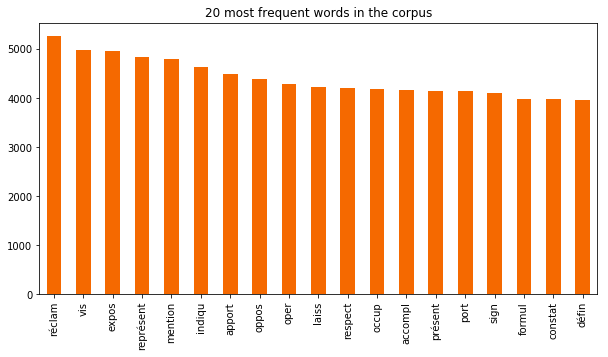

In [43]:
df_fq3 = pd.DataFrame.from_dict(freq_totale3, orient='index')

df1_fq3 = df_fq3.sort_values(0, ascending=False)
df2_fq3 = df1_fq3.iloc[0:19,:].copy()
df2_fq3.plot(kind='bar', color="#f56900",legend=False, title='20 most frequent words in the corpus', figsize=(10,5));                                     


When we plot the 20 most frequent words in the corpus we can clearly see law vocabulary showing up such as “condamn”, “compt” etc...

# Part 2: Transform textual data

## A. Represent the corpus of text as a “bag-of-words” 

The bag of words approach is very intuitive: we simply consider every Cour de cassation decision as a whole of words, without any consideration of contexte (order, how it is used…). 

Now that this term-document matrix is created, another step is necessary for this approach to make sense. Indeed, in language analysis it is essential to capture the co-dependencies of the words in a text.

One technique is to weigh up or down the importance of a word in a text relatively to the whole corpus of texts - if they only appear in this text, it should be noticed and weighed up, and the opposite if they in fact appear in most of the documents. This technique is called the *Term Frequency-Inverse Document Frequency (TF-IDF)*.


In [67]:
#run with the list of 85 stopwords
translator = str.maketrans('', '', string.punctuation)

path = "/Users/lamazere/Desktop/Pour mémoire/Test2018"
os.chdir(path)

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

token_dict = dict()

for subdir, dirs, files in os.walk(path):
    for file in files:
        file_path = subdir + os.path.sep + file
        shakes = open(file_path, 'r', encoding = "ISO-8859-1")
        text = shakes.read()
        lowers = text.lower()
        no_punctuation = lowers.translate(translator) #removes punctuation
        token_dict[file] = no_punctuation

        
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=sw)
values = tfidf.fit_transform(token_dict.values())

In [45]:
values

<1056x38311 sparse matrix of type '<class 'numpy.float64'>'
	with 329260 stored elements in Compressed Sparse Row format>

When applying TF-IDF to our corpus, the result is then a sparse matrix, each row representing an "arrêt" and each column a token of the corpus. The sparse matrix format is very useful for mathematical calculation purposes and more efficient storage wise.
As TF-IDF is quite accurate, we can use it to do non-supervised representations, like *t-SNE*, to bring together “arrêts” with similar TF-IDF indicators.

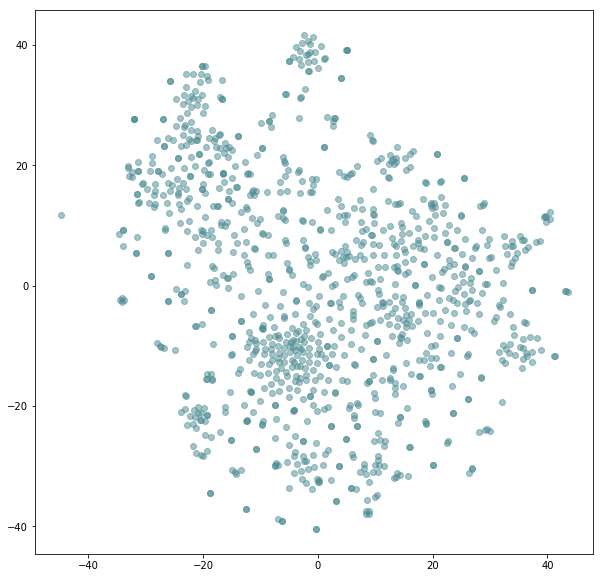

In [68]:
X_tsne = TSNE(n_components=2, perplexity = 60,  learning_rate= 60, n_iter = 8000).fit_transform(values.toarray())

df_tsne = pd.DataFrame(X_tsne,columns=["X","Y"])

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(df_tsne["X"], df_tsne["Y"], alpha = 0.5, color = "#4A8B92");

We can clearly see some clusters appearing that could correspond to common thematics. As our dataset is not labelled, we will try next to determine those clusters by different methods.

## C. Topic modelling with unsupervised methods

### C.1. Latent Dirichlet Allocation (LDA) Method 

The LDA topic model algorithm requires a document word matrix as the main input. As a result, we need to change the format of our database to this purpose.

In [69]:
def load_all_texts_array():
    db = []
    for i in range(1,1038):
        droit=open("/Users/lamazere/Desktop/Pour mémoire/all_2018/text%s.txt"%i,"r").read()
        db.append(droit)
    return db

db = load_all_texts_array();

We create the document word matrix using CountVectorizer. In the below code, we have configured the CountVectorizer to consider words that have occurred at least 10 times (min_df) and ingnore terms that have occured more than 95% of the documents, remove our own stopwords.

In [70]:
tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=10,                      # minimum reqd occurences of a word 
                                stop_words=sw,
                                max_features=50000)             # max number of uniq words 
tf = tf_vectorizer.fit_transform(db)

Since most cells in this matrix will be zero, we want to know what percentage of cells contain non-zero values. We can see it is very low.

In [71]:
# Materialize the sparse data
data_dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  6.4204097829658915 %


We build our LDA model based on this matrix with the hyperparameter "number of topics" set to 10. 

In [72]:
lda_model = LatentDirichletAllocation(n_components=10,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(tf)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


It is essential to validate this first model, as it has been selected a priori. We use the log-likelihood and the perplexity to evaluate the goodness-of-fit.


In [73]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tf))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -9047081.067993758
Perplexity:  2006.1431944561532
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'n_topics': None, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


We are going to look for the best model. n LDA, the core parameter is the number of topics and, in addition, we chose to search the learning rate as well.

In [74]:
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [5, 10, 15, 20, 25], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -3134752.236905373
Model Perplexity:  2123.7372780493597


Once we know which LDA model is the best, we check the topics allocation. We built a table that underlines in green the highest probability scores of a given topic in a document and thus selects the most relevant topic for the document.

In [76]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(tf)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(db))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0,0.14,0.83,0.03,0,2
Doc1,0.62,0,0,0.16,0.22,0
Doc2,0,0,0,0.94,0.06,3
Doc3,0.66,0,0,0,0.34,0
Doc4,0,0.08,0.19,0,0.72,4
Doc5,0,1,0,0,0,1
Doc6,0.01,0.58,0,0.41,0,1
Doc7,0,0,0,0.05,0.95,4
Doc8,0.27,0,0,0.2,0.53,4
Doc9,0,0,0,0.4,0.6,4


We also check the distribution of topics across the corpus.


In [77]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,362
1,2,301
2,4,193
3,3,127
4,0,54


We want to show some keywords for each topic.

In [78]:
# Show the n keywords for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx) )
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(best_lda_model, tf_vectorizer.get_feature_names(), 10)

Topic 0:
poste parcelle entre activité comme parcelles convention complément zone indemnité
Topic 1:
civil vente parties acte jugement sci travaux 000 date violé
Topic 2:
instruction pénale juge examen tribunal mise ordonnance faits avocat 2018
Topic 3:
préjudice éléments monsieur employeur faute assurance dommages 2012 000 temps
Topic 4:
salarié employeur licenciement accord sociale entreprise salaire cause conditions dispositions


This model seems to be pretty accurate. We can clearly see that the topics put under the spotlight different branches of the law:
- Topic 0 deals with property law

- Topic 1 deals with liability law

- Topic 2 deals with criminal law

- Topic 3 deals with general civil law

- Topic 4 deals with social law (= labour law)


Once we have defined our best model and found the ideal number of topics, we would like to plot the results. To this end, we use cluster algorithm, a basic class of unsupervised machine learning models. Clustering divides the data in groups according to their similarities and their properties. We will use *k-means clustering* from the package Scikit-Learn, as it is the most frequently used.

We use the k-means algorithm with 5 clusters - the number of topics of our ideal LDA model previously found. It would have also been possible to define the clusters with the probability scores calculated in the above table. To plot the graph, we need our two dimensions that correspond to the axis of the graph. To do so, we have to build a truncated *Singular Value Decomposition (SVD)* to reduce dimensionality and apply it to our best LDA model data. 

In [79]:
# Construct the k-means clusters
clusters = KMeans(n_clusters=5, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 5 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.08  0.74  0.62  0.17  0.16]
 [-0.04 -0.64  0.77 -0.02  0.03]]
Perc of Variance Explained: 
 [0.1  0.45]


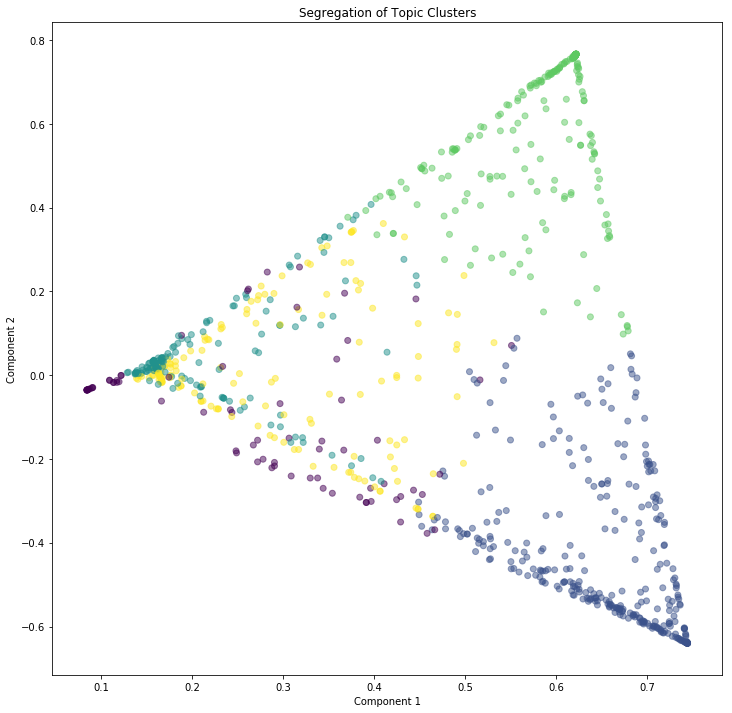

In [80]:
# Plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(x, y, c=clusters, alpha = 0.5);
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title("Segregation of Topic Clusters");

We wish to visualize the clusters of documents in a 2D space using t-SNE algorithm mentioned in Part 2. A.


In [81]:
colormap = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

X_topics = best_lda_model.fit_transform(tf)
X_tsne = TSNE(n_components=2, perplexity = 60,  learning_rate= 60, n_iter = 8000).fit_transform(X_topics)

In [82]:
_lda_keys = []
for i in range(X_topics.shape[0]):
    _lda_keys +=  X_topics[i].argmax(),

# create the dictionary with all the information   
num_example = len(X_topics)

plot_dict = {
        'x': np.array(X_tsne[:num_example, 0]),
        'y': np.array(X_tsne[:num_example, 1]),
        'colors': colormap[_lda_keys][:num_example],
        'content': db[:num_example],
        'topic_key': _lda_keys[:num_example]
        }

# create the dataframe from the dictionary
plot_df = pd.DataFrame.from_dict(plot_dict)

#remove all the Na values and set everything to float
plot_df = plot_df.fillna(0)

plot_df['x'] = pd.to_numeric(plot_df['x'])
plot_df['y'] = pd.to_numeric(plot_df['y'])


# declare the source    
source = bp.ColumnDataSource(data=plot_df)
title = 't-SNE Clustering of 5 LDA Topics'

# initialize bokeh plot
plot_lda = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

# build scatter function from the columns of the dataframe
plot_lda.scatter('x', 'y', color='colors', source=source);


# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"topic": "@topic_key"}

output_file("plot_lda.html")
show(plot_lda)

### C.2. Negative Matrix Factorisation (NMF) Method 

We try another method : the *Non-negative Matrix Factorisation (NMF)* method. In practice, NMF is commonly used in topic modelling because it uses context, improving topic prediction. We decide to apply NMF to our corpus of texts. The results are the following:


In [83]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=500, stop_words=sw)
tfidf = tfidf_vectorizer.fit_transform(db)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


# Run NMF
nmf_model = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf_output = nmf_model.fit(tfidf)

no_top_words = 10
display_topics(nmf_output, tfidf_feature_names, no_top_words)

Topic 0:
vente travaux époux civil sci monsieur 000 parties préjudice entre
Topic 1:
pénale conseiller 2018 instruction greffier contre faits ordonnance foi examen
Topic 2:
licenciement salarié employeur salaire salariée indemnité sérieuse poste rupture réelle
Topic 3:
sécurité sociale chsct caisse accord maladie établissement recours charge conditions
Topic 4:
acte 2018 pourvoi formé déclaré contre france rapport sociale 700


We can again assign clearly different branches of the law to the topics, except for the last topic:

- Topic 0 deals with property law

- Topic 1 deals with criminal law

- Topic 2 deals with social law (= labour law)

- Topic 3 deals with social security law

- Topic 4 remains quite hard to interpret

In [84]:
# Create Document - Topic Matrix
nmf_output = nmf_model.fit_transform(tfidf)

# column names
topicnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(db))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

When we take a closer look at topic allocation, a low number of documents are represented by the topic 4. 


In [85]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,507
1,1,193
2,2,171
3,3,109
4,4,57


We decide to use again k-means algorithm to plot the clusters. We finally plot the clusters of documents in a 2D space using t-SNE algorithm.


In [86]:
# Construct the k-means clusters
clusters = KMeans(n_clusters=5, random_state=100).fit_predict(nmf_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
nmf_output_svd = svd_model.fit_transform(nmf_output)

# X and Y axes of the plot using SVD decomposition
x = nmf_output_svd[:, 0]
y = nmf_output_svd[:, 1]

# Weights for the 5 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.76  0.42  0.4   0.24  0.14]
 [-0.14 -0.55  0.81  0.08 -0.1 ]]
Perc of Variance Explained: 
 [0.02 0.34]


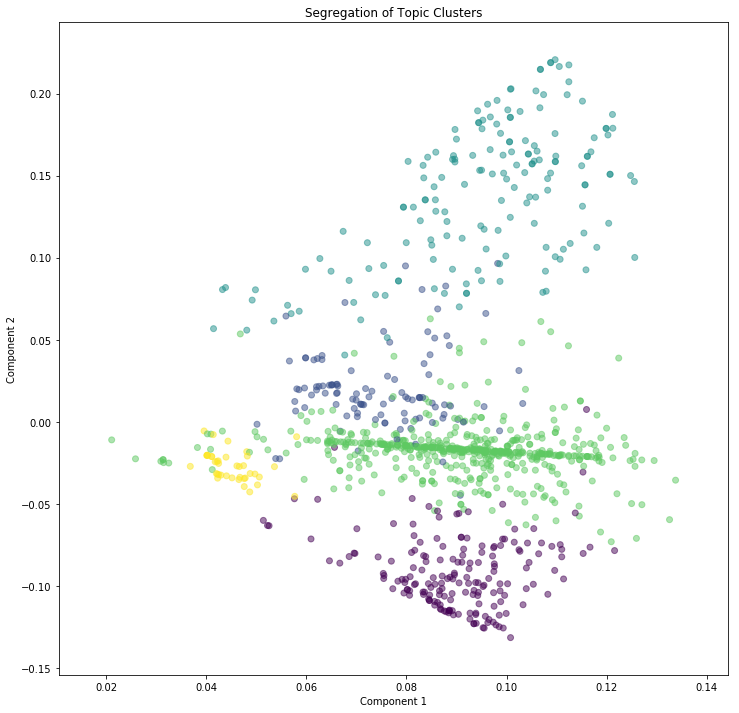

In [87]:
# Plot
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(x, y, c=clusters, alpha = 0.5);
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title("Segregation of Topic Clusters");

In [ ]:
X_topics = nmf_model.fit_transform(tfidf)
X_tsne = TSNE(n_components=2, perplexity = 60,  learning_rate= 60, n_iter = 8000).fit_transform(X_topics)

In [ ]:
colormap = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

_lda_keys = []
for i in range(X_topics.shape[0]):
    _lda_keys +=  X_topics[i].argmax(),

# create the dictionary with all the information   
num_example = len(X_topics)

plot_dict = {
        'x': np.array(X_tsne[:num_example, 0]),
        'y': np.array(X_tsne[:num_example, 1]),
        'colors': colormap[_lda_keys][:num_example],
        'content': db[:num_example],
        'topic_key': _lda_keys[:num_example]
        }

# create the dataframe from the dictionary
plot_df = pd.DataFrame.from_dict(plot_dict)

#remove all the Na values and set everything to float
plot_df = plot_df.fillna(0)

plot_df['x'] = pd.to_numeric(plot_df['x'])
plot_df['y'] = pd.to_numeric(plot_df['y'])


# declare the source    
source = bp.ColumnDataSource(data=plot_df)
title = 't-SNE Clustering of 5 NMF Topics'

# initialize bokeh plot
plot_nmf = bp.figure(plot_width=1400, plot_height=1100,
                     title=title,
                     tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

# build scatter function from the columns of the dataframe
plot_nmf.scatter('x', 'y', color='colors', source=source);


# hover tools
hover = plot_nmf.select(dict(type=HoverTool))
hover.tooltips = {"topic": "@topic_key"}

output_file("plot_nmf.html")
show(plot_nmf)

## Word Embeding

In [60]:
path="/Users/lamazere/Desktop/Pour mémoire/all_2018"
os.chdir(path)

try:
    model = gensim.models.Word2Vec.load("word2vec.model")  # gets back our stored model
except IOError: # re-train only if required.
    model = gensim.models.Word2Vec(tokenized_sentences, min_count=1, workers=24)

In [61]:
read_files = glob.glob("*.txt")
temporary_file_name = "concatenated_texts.txt"
#creates a file containing all texts
with open(temporary_file_name, "wb") as outfile:
    for f in read_files:
        with open(f, "rb") as infile:
            outfile.write(infile.read())

all_texts_str = open(temporary_file_name,"r").read() #variable containing all texts in str format
os.remove(temporary_file_name) #delete the file

sentences = nltk.sent_tokenize(all_texts_str)
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

print("there in total this number of words in our corpus",len(all_texts_str))

there in total this number of words in our corpus 147272258


In [62]:
model.most_similar(positive=['titres'], topn=5)

[('actifs', 0.7816277742385864),
 ('immeubles', 0.7470481395721436),
 ('biens', 0.7315032482147217),
 ('parts', 0.7016721963882446),
 ('cessions', 0.6811667680740356)]